<a href="https://colab.research.google.com/github/cemkaboglu/whole_mouse_brain_MERFISH_atlas_scripts_2023/blob/main/Copy_of_scCODA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scCODA - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *scCODA* package ([Büttner, Ostner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6)) to analyze changes in cell composition data.

The package is intended to be used with cell composition from single-cell RNA-seq experiments, however there are no technical
restrictions that prevent the use of data from other sources.

The data we use in the following example comes from [Haber et al., 2017](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.

This tutorial is designed to be executed on a standard computer (any operating system) in a Python environment with scCODA, Jupyter notebook and all their dependencies installed.
Running the tutorial takes about 1.5 minutes on a 2020 Apple MacBook Pro (16GB RAM).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir new_drive_folder

Mounted at /content/drive


In [ ]:
!pip install sccoda


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=cea2d0254e9dc01519fa5304c0eeb838f52213b013c9331a0e579583e386e75c
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

### Data preparation

In [ ]:
# Load data
cell_counts = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/results/sccoda_2e_merfish.csv", sep = ",")

print(cell_counts)

        Var1  Neurons - Glutamatergic  Oligodendrocytes  Astrocytes  \
0     F_2e_1                     9919              4934        5087   
1     F_2e_3                    11312              4016        4570   
2  F_cntrl_1                     9181              4989        4360   
3  F_cntrl_3                     7972              3605        3576   

   Endothelial cells  GABAergic, Neurons  Microglia  Immune  \
0               4019                3862       3313    1109   
1               3705                3901       1929    3439   
2               3355                3053       1886    1249   
3               2888                2072       1425    1724   

   Neurons - GABAergic  Ligand Chemokine,Signalling  OPCs  \
0                 4113                            0  1302   
1                 3918                            0  1216   
2                 2452                            0   810   
3                 3174                            0   783   

   Neurons - DG Glutam

In [ ]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Var1"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Genotype"] = data_all.obs["Var1"].str.replace(r"_[0-5]", "", regex=True)
print(data_all)
print(data_all.obs["Genotype"].unique())


AnnData object with n_obs × n_vars = 4 × 18
    obs: 'Var1', 'Genotype'
['Fe' 'F_cntrl']


For our first example, we want to look at how the Salmonella infection influences the cell composition.
Therefore, we subset our data.

In [ ]:
# Select control and salmonella data
data_salm = data_all[data_all.obs["Genotype"].isin(["F_cntrl","Fe"])]
print(data_salm.obs)


        Var1 Genotype
0     F_2e_1       Fe
1     F_2e_3       Fe
2  F_cntrl_1  F_cntrl
3  F_cntrl_3  F_cntrl


Plotting the data, we can see that there is a large increase of Enterocytes in the infected sampes, while most other cell types slightly decrease.
Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types.
Thus, the slight decreases in many cell types might be fully caused by the increase in Enterocytes.

<Figure size 1500x600 with 0 Axes>

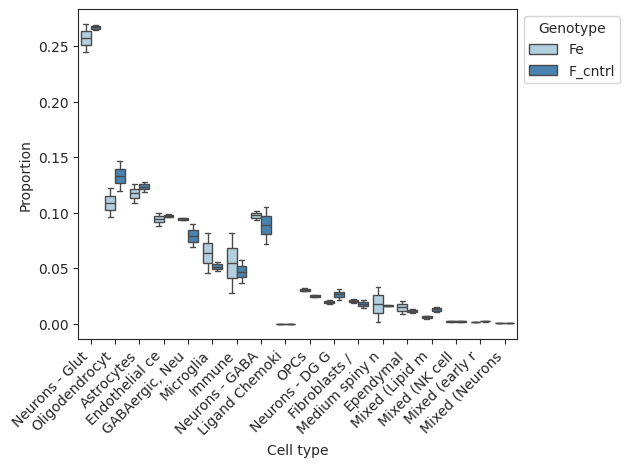

In [ ]:
# Increase the figure size with more height to avoid squished y-axis
plt.figure(figsize=(15, 6))  # Adjust the width (15) and height (6) as needed for better spacing

viz.boxplots(data_salm, feature_name="Genotype")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Get current x-tick labels
labels = plt.xticks()[1]

# Shorten the labels for cleaner look
new_labels = [label.get_text()[:14] for label in labels]  # Adjust slicing length as necessary

# Set new labels
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)

# Apply a tight layout to avoid overlapping
plt.tight_layout()

# Show the updated plot
plt.show()


<Figure size 1500x600 with 0 Axes>

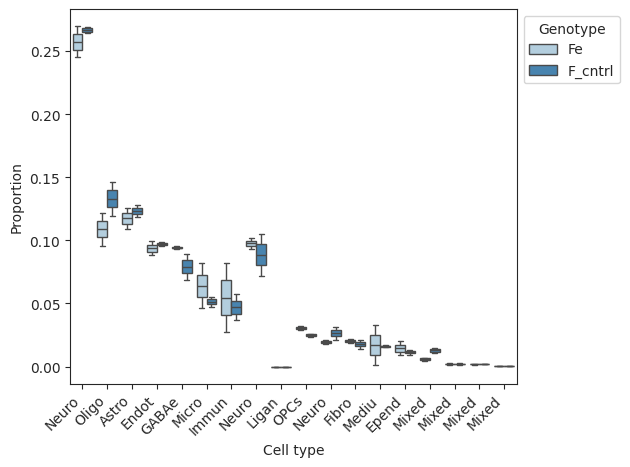

In [ ]:
# Increase the figure size with more height to avoid squished y-axis
plt.figure(figsize=(15, 6))  # Adjust the width (15) and height (6) as needed for better spacing

viz.boxplots(data_salm, feature_name="Genotype")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Get current x-tick labels
labels = plt.xticks()[1]

# Shorten the labels for cleaner look
new_labels = [label.get_text()[:5] for label in labels]  # Adjust slicing length as necessary

# Set new labels
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)

# Apply a tight layout to avoid overlapping
plt.tight_layout()

# Show the updated plot
plt.show()


*Note that the use of* anndata *in* scCODA *is different from the use in scRNA-seq pipelines, e.g.* scanpy.
*To convert* scanpy *objects to a scCODA dataset, have a look at `dat.from_scanpy.*

### Model setup and inference

We can now create the model and run inference on it. Creating a `sccoda.util.comp_ana.CompositionalAnalysis` class object
sets up the compositional model and prepares everxthing for parameter inference. It needs these informations:

- The data object from above.

- The `formula` parameter. It specifies how the covariates are used in the model.
It can process R-style formulas via the [patsy](https://patsy.readthedocs.io/en/latest/) package, e.g. `formula="Cov1 + Cov2 + Cov3"`.
Here, we simply use the "Condition" covariate of our dataset

- The `reference_cell_type` parameter is used to specify a cell type that is believed to be unchanged by the covariates in `formula`.
This is necessary, because compositional analysis must always be performed relative to a reference (See [Büttner, Ostner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6) for a more thorough explanation).
If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice.
It is also possible to let scCODA find a suited reference cell type by using `reference_cell_type="automatic"`.
Here, we take Goblet cells as the reference.

In [ ]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Genotype", reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to Mixed (early response/astrocyte, Interferon)
Zero counts encountered in data! Added a pseudocount of 0.5.


HMC sampling is then initiated by calling `model.sample_hmc()`, which produces a `sccoda.util.result_classes.CAResult` object.

In [ ]:
# Run MCMC
sim_results = model_salm.sample_hmc()

100%|██████████| 20000/20000 [02:38<00:00, 126.23it/s]


MCMC sampling finished. (200.106 sec)
Acceptance rate: 83.6%


### Result interpretation

Calling `summary()` on the results object, we can see the most relevant information for further analysis:

In [ ]:
sim_results.summary()

Compositional Analysis summary:

Data: 4 samples, 18 cell types
Reference index: 16
Formula: Genotype

Intercepts:
                                                    Final Parameter  \
Cell Type                                                             
Neurons - Glutamatergic                                       4.440   
Oligodendrocytes                                              3.670   
Astrocytes                                                    3.657   
Endothelial cells                                             3.437   
GABAergic, Neurons                                            3.324   
Microglia                                                     2.902   
Immune                                                        2.724   
Neurons - GABAergic                                           3.392   
Ligand Chemokine,Signalling                                  -5.099   
OPCs                                                          2.214   
Neurons - DG Glutamatergic       

**Model properties**

First, the summary shows an overview over the model properties:
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has two types of parameters that are relevant for analysis - intercepts and effects.
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show ho the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values.
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Effects**

For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types.
Most important is the distinctions between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Final Parameter" column are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, can still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint.
If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

**Interpretation**

In the salmonella case, we see only a credible increase of Enterocytes, while all other cell types are unaffected by the disease.
The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.54.

We can also easily filter out all credible effects:

In [ ]:
print(sim_results.credible_effects())



Covariate       Cell Type                                                
Genotype[T.Fe]  Neurons - Glutamatergic                                      False
                Oligodendrocytes                                             False
                Astrocytes                                                   False
                Endothelial cells                                            False
                GABAergic, Neurons                                           False
                Microglia                                                    False
                Immune                                                       False
                Neurons - GABAergic                                          False
                Ligand Chemokine,Signalling                                   True
                OPCs                                                         False
                Neurons - DG Glutamatergic                                   False
             

### Adjusting the False discovery rate

scCODA selects credible effects based on their inclusion probability.
The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR).
A smaller FDR value will produce more conservative results, but might miss some effects,
while a larger FDR value selects more effects at the cost of a larger number of false discoveries.

The desired FDR level can be easily set after inference via `sim_results.set_fdr()`. Per default, the value is 0.05,
but we recommend to increase it if no effects are found at a more conservative level.

In our example, setting a desired FDR of 0.4 reveals effects on Endocrine and Enterocyte cells.

!!!! Default is 0.05 maybe max to 0.1 but when you change check if the significance is both ways (a to b and also b to a)


In [ ]:
sim_results.set_fdr(est_fdr=0.4)
sim_results.summary()

Compositional Analysis summary:

Data: 4 samples, 18 cell types
Reference index: 16
Formula: Genotype

Intercepts:
                                                    Final Parameter  \
Cell Type                                                             
Neurons - Glutamatergic                                       4.440   
Oligodendrocytes                                              3.670   
Astrocytes                                                    3.657   
Endothelial cells                                             3.437   
GABAergic, Neurons                                            3.324   
Microglia                                                     2.902   
Immune                                                        2.724   
Neurons - GABAergic                                           3.392   
Ligand Chemokine,Signalling                                  -5.099   
OPCs                                                          2.214   
Neurons - DG Glutamatergic       

### Saving results

The compositional analysis results can be saved as a pickle object via `results.save(<path_to_file>)`.

In [ ]:
# saving
path = "test"
sim_results.save(path)

# loading
with open(path, "rb") as f:
    sim_results_2 = pkl.load(f)

sim_results_2.summary()

Compositional Analysis summary:

Data: 6 samples, 9 cell types
Reference index: 7
Formula: Genotype

Intercepts:
                           Final Parameter  Expected Sample
Cell Type                                                  
Homeostatic                          3.578       820.204307
PIGs                                 2.964       443.879649
Neuronal_contamination               2.527       286.733572
Astro_contamination                  2.288       225.778282
Endothelial_contamination            2.184       203.477099
Immune,                              0.926        57.832648
Activated                            0.806        51.292958
Myelination                          0.827        52.381499
Homeostatic_pval                     0.057        24.253319


Effects:
                                                Final Parameter  \
Covariate            Cell Type                                    
Genotype[T.5xFAD_WT] Homeostatic                            0.0   
               

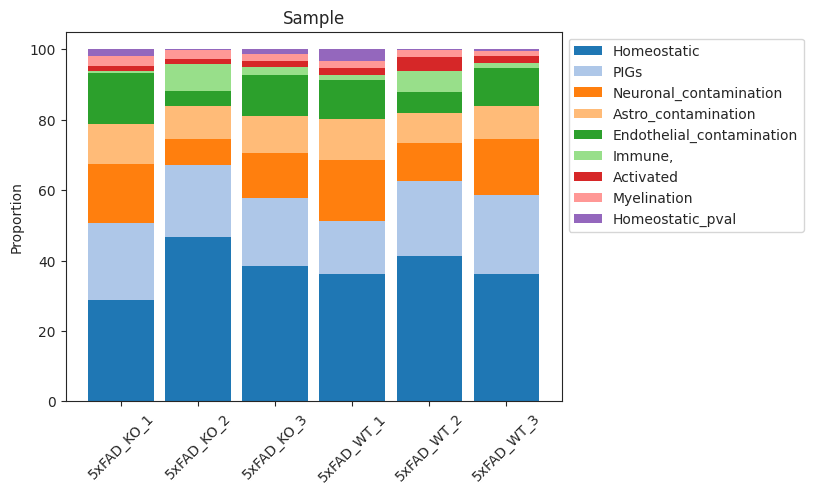

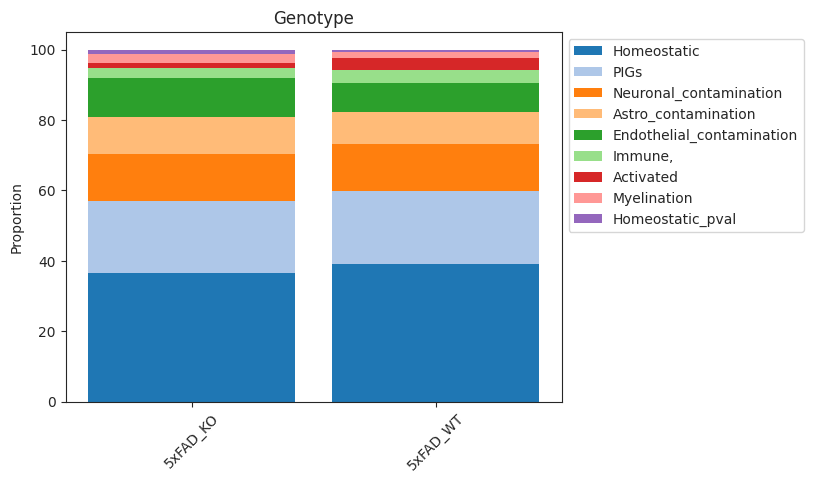

In [ ]:
# Stacked barplot for each sample
viz.stacked_barplot(data_all, feature_name="Sample")
plt.show()

# Stacked barplot for the levels of "Condition"
viz.stacked_barplot(data_all, feature_name="Genotype")
plt.show()

In [ ]:
sim_results.summary_extended(hdi_prob=0.9)


Compositional Analysis summary (extended):

Data: 4 samples, 18 cell types
Reference index: 16
Formula: Genotype
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 219.705 sec. Acceptance rate: 46.9%

Intercepts:
                                                    Final Parameter  HDI 5%  \
Cell Type                                                                     
Neurons - Glutamatergic                                       4.420   4.048   
Oligodendrocytes                                              3.650   3.257   
Astrocytes                                                    3.645   3.292   
Endothelial cells                                             3.411   3.084   
GABAergic, Neurons                                            3.296   2.925   
Microglia                                                     2.872   2.475   
Immune                                                        2.696   2.295   
Neurons - GABAergic        